## Removing the 1-halo term form the sims:

In [7]:
import numpy as np
from scipy.spatial import cKDTree

def halo_exclusion(pos, mass, r200, boxsize=None):
    """
    Perform halo exclusion by removing smaller halos within the R200 of more massive halos.

    Parameters
    ----------
    pos : ndarray of shape (N, 3)
        Positions of halos (in Mpc/h).
    mass : ndarray of shape (N,)
        Masses of halos (in Msun/h), used to sort halos.
    r200 : ndarray of shape (N,)
        R200 radius of halos (in Mpc/h).
    boxsize : float, optional
        If given, apply periodic boundary conditions.

    Returns
    -------
    keep_mask : ndarray of bool
        Boolean mask array indicating which halos are kept.
    """

    N = len(mass)
    idx_sorted = np.argsort(-mass)  # Sort by decreasing mass
    pos = pos[idx_sorted]
    r200 = r200[idx_sorted]

    keep_mask = np.ones(N, dtype=bool)
    tree = cKDTree(pos, boxsize=boxsize)

    for i in range(N):
        if not keep_mask[i]:
            continue  # Already excluded

        # Query neighbors within this halo's r200
        neighbors = tree.query_ball_point(pos[i], r200[i])
        for j in neighbors:
            if j <= i:
                continue  # Only exclude lower-mass halos
            keep_mask[j] = False

    # Map keep_mask back to original order
    inverse_sort = np.argsort(idx_sorted)
    return keep_mask[inverse_sort]

In [8]:
from gal_goku_sims import xi

base_dir = '/scratch/06536/qezlou/Goku/FOF/L2/'
z = 2.5
narrow = False

corr= xi.Corr()
pigs = corr.get_pig_dirs(base_dir, z=2.5, narrow=narrow)

for i in range(21):
    cosmo = corr.get_cosmo(pigs['params'][i])
    halos = corr.load_halo_cat(pigs['pig_dirs'][i], cosmo=cosmo)
    pos = halos['Position'].compute()
    mass = halos['Mass'].compute()
    r200 = halos['Radius'].compute()
    boxsize = halos.attrs['BoxSize'][0]
    keep_mask = halo_exclusion(pos, mass, 10*r200, boxsize=boxsize)
    print(f'for {i} : {np.where(keep_mask)[0].size/ halos.size}, counts removed: {np.sum(~keep_mask)}')

[ 000000.01 ]   0: 05-27 13:58  get corr        INFO     Logger initialized at level: 20
[ 000000.02 ]   0: 05-27 13:58  get corr        INFO     MPI_COMM_WORLD | size = 1 -- Nbkit COMM | size = 1
[ 000000.03 ]   0: 05-27 13:58  get corr        INFO     base_dir = /scratch/06536/qezlou/Goku/FOF/L2/ | number of sims = 151, z = 2.5


for 0 : 0.9050741589672093, counts removed: 24103
for 1 : 0.8980237451864684, counts removed: 10831
for 2 : 0.8707354631119283, counts removed: 56243
for 3 : 0.8690085376721189, counts removed: 45568
for 4 : 0.9462431746520034, counts removed: 1398
for 5 : 0.8663883864182365, counts removed: 61233
for 6 : 0.9228668377058677, counts removed: 9320
for 7 : 0.8468576612091926, counts removed: 89814
for 8 : 0.881691417907163, counts removed: 26879
for 9 : 0.9347843875296621, counts removed: 797
for 10 : 0.8669091635138664, counts removed: 51993
for 11 : 0.8390050682392681, counts removed: 114578
for 12 : 0.883693214485613, counts removed: 61092
for 13 : 0.9169112438012347, counts removed: 5747
for 14 : 0.8556011592156171, counts removed: 49079
for 15 : 0.8841776469321079, counts removed: 19356
for 16 : 0.9338556965734739, counts removed: 9480
for 17 : 0.8998370544626574, counts removed: 18564
for 18 : 0.937159588200107, counts removed: 1996
for 19 : 0.902972642801614, counts removed: 18347


In [5]:
np.min(r200), np.max(r200), np.mean(r200), np.std(r200)

(0.03154554476534708,
 0.26945865079497766,
 0.042546314274041826,
 0.013226832581339847)

In [13]:
from colossus.halo import mass_defs
from colossus.halo import concentration
from colossus.cosmology import cosmology as colossus_cosmology

# Set up Colossus cosmology
colossus_cosmology.setCosmology('planck18')


def get_halo_props_colossus(m_vir, z=2.5):
    """
    Get halo properties using Colossus.

    Parameters
    ----------
    mvir : float
        The virial mass of the halo
    z : float
    """
    # gEt the concentration parameter
    c_vir = concentration.concentration(M=m_vir, z=z, mdef='vir')
    # Get the virial radius
    _, r_vir, _ = mass_defs.changeMassDefinition(m_vir, c_vir, z, 'vir', '200m')
    return c_vir, r_vir

_, r_vir = get_halo_props_colossus(mass[2400], z=2.5)
r_vir

66.42823470092551

In [14]:
r200[2400]

0.067253444019286

Fully implement in the source code:

In [7]:
import importlib
from gal_goku_sims import xi
importlib.reload(xi)

base_dir = '/scratch/06536/qezlou/Goku/FOF/L2/'
z = 2.5
narrow = False

corr= xi.Corr()
pigs = corr.get_pig_dirs(base_dir, z=2.5, narrow=narrow)
corr.load_halo_cat(pigs['pig_dirs'][10], cosmo=corr.get_cosmo(pigs['params'][0]))
#xi_h, rbins = corr._get_corr(pigs['pig_dirs'][0], cosmo=corr.get_cosmo(pigs['params'][0]), mass_th=[12.0,12.0], z=z)

[ 000000.00 ]   0: 05-27 14:28  get corr        INFO     Logger initialized at level: 20
[ 000000.00 ]   0: 05-27 14:28  get corr        INFO     MPI_COMM_WORLD | size = 1 -- Nbkit COMM | size = 1
[ 000000.72 ]   0: 05-27 14:28  get corr        INFO     base_dir = /scratch/06536/qezlou/Goku/FOF/L2/ | number of sims = 151, z = 2.5
[ 000008.08 ]   0: 05-27 14:28  get corr        INFO     Rank 0 removed 15.62% of halos due to exclusion with radius 10*R200


HaloCatalog(size=329641)

Test the xi(r) with 10*R200:

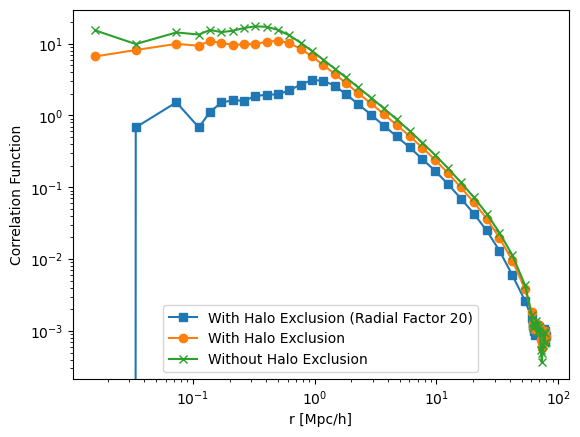

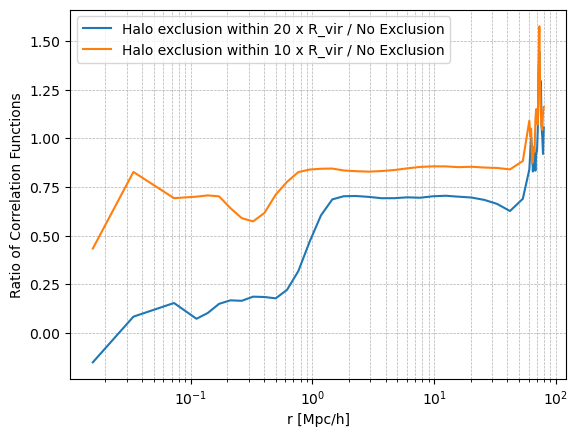

In [7]:
from matplotlib import pyplot as plt
import h5py
import numpy as np


with h5py.File('test_xi_ex.h5','r') as f:
    rbins = f['rbins'][:]
    xi_h = f['xi_h'][:]
with h5py.File('test_xi_no_ex.h5','r') as f:
    rbins_no_ex = f['rbins'][:]
    xi_h_no_ex = f['xi_h'][:]
with h5py.File('test_xi_ex_rad_fac_20.h5','r') as f:
    rbins_rad_fac_20 = f['rbins'][:]
    xi_h_rad_fac_20 = f['xi_h'][:]
plt.loglog(rbins_rad_fac_20, xi_h_rad_fac_20, label='With Halo Exclusion (Radial Factor 20)', marker='s')
plt.loglog(rbins, xi_h, label='With Halo Exclusion', marker='o')
plt.loglog(rbins_no_ex, xi_h_no_ex, label='Without Halo Exclusion', marker='x')
plt.legend()
plt.xlabel('r [Mpc/h]')
plt.ylabel('Correlation Function')

fig, ax = plt.subplots()
ax.plot(rbins, xi_h_rad_fac_20/xi_h, label='Halo exclusion within 20 x R_vir / No Exclusion')
ax.plot(rbins, xi_h/xi_h_no_ex, label='Halo exclusion within 10 x R_vir / No Exclusion')


ax.set_xlabel('r [Mpc/h]')
ax.set_ylabel('Ratio of Correlation Functions')
ax.legend()
ax.set_xscale('log')
ax.grid(which='both', linestyle='--', linewidth=0.5)


## Comapre to Rockstar

In [4]:
## Get ASCII file to raed with rockstar
import bigfile
from os import path as op
def bigfile_to_ascii(part_dir, save_dir):
    """
    Convert a BigFile particle catalog to an ASCII file.
    Parameters
    ----------
    part_dir : str
        Path to the BigFile particle catalog.
    ascii_file : str
        Path to the output ASCII file.
    """
    # Rockstar expects positions in Mpc/h and velocities in km/s
    # Make sure the units are correct; apply conversion if needed
    with bigfile.BigFile(part_dir,'r') as bf:
        pos = bf['1/Position'][:]/1000
        vel = bf['1/Velocity'][:]
        mass = bf['1'].attrs['MassTable'][1]*1e10
        ids = bf['1/ID'][:]
        boxsize = bf['1'].attrs['BoxSize'][0]/1000 

    # Write rockstar.cfg
    config_file = op.join(save_dir, 'rockstar.cfg')
    ascii_file = op.join(save_dir, 'rockstar_ascii.txt')
    with open(config_file, 'w') as f:
        f.write(f"""
        INBASE = {ascii_file}
        OUTBASE = ./output
        FORCE_RES = 0.05
        PARTICLE_MASS = {mass}e10
        BOX_SIZE = {boxsize}
        NUM_SNAPS = 1
        SNAP_FORMAT = 3  # ascii
        FULL_PARTICLE_CHUNKS = 1
        OVERLAP_LENGTH = 0.1
        BINARY_OUTPUT = 1
                """)
    # Write to ASCII file
    with open(ascii_file, 'w') as f:
        for i in range(pos.shape[0]):
            line = f"{pos[i,0]} {pos[i,1]} {pos[i,2]} {vel[i,0]} {vel[i,1]} {vel[i,2]} {mass} {ids[i]}\n"
            f.write(line)


part_dir = '/scratch/06536/qezlou/Goku/FOF/L2/compressed_10p_Box250_Part750_0098/output/PART_003'
save_dir ='/scratch/06536/qezlou/Goku/FOF/rock_halos'
bigfile_to_ascii(part_dir, save_dir)

MemoryError: Unable to allocate 4.71 GiB for an array with shape (421875000, 3) and data type float32

## SubFind in Astrid:

In [10]:
import bigfile
import numpy as np

save_dir = '/home/qezlou/HD1/simulations/ASTRID/SFR'
bf = bigfile.File(save_dir)
# Get the available blocks
print("Available blocks:", bf.blocks)

# Open one of the blocks to examine its structure

with bf['SubhaloRankInGr'] as f:
    print("Attributes:", f.attrs)
    print("Size:", f.size)
    if f.size > 0:
        print("Fraction of centrals", 1 - np.where(f[:])[0].size / f.size)
        ind =  np.where(f[:] == 0)
with bf['SubhaloMass'] as f:
    print(f.attrs, f.size, f[:].shape)
    mass = np.log10(f[:]) + 10

Available blocks: ['SubhaloCM', 'SubhaloMass', 'SubhaloParentRank', 'SubhaloRankInGr']
Attributes: <BigAttr ()>
Size: 57708467
Fraction of centrals 0.5717633601322316
<BigAttr ()> 57708467 (57708467,)


/tmp/ipykernel_1687021/2837843241.py:11: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(mbins, hist_cen/hist_all, drawstyle='steps', label='All', color='C1')


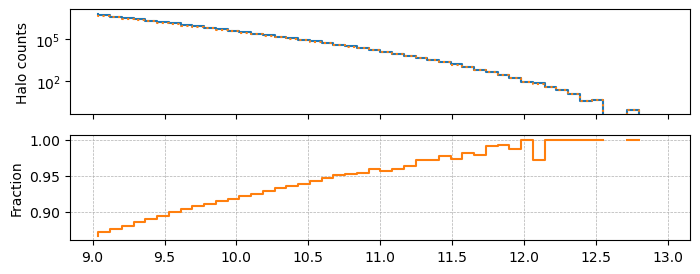

In [12]:
from matplotlib import pyplot as plt
import numpy as np
    
fig, ax = plt.subplots(2,1, figsize=(8, 3), sharex=True)
bins = np.linspace(9, 13, 50)
mbins = (bins[:-1] + bins[1:]) / 2
hist_all, _ = np.histogram(mass, bins=bins)
ax[0].plot(mbins, hist_all, drawstyle='steps', label='All', color='C0')
hist_cen, _ = np.histogram(mass[ind], bins=bins)
ax[0].plot(mbins, hist_cen, drawstyle='steps', label='All', color='C1', ls='dotted')
ax[1].plot(mbins, hist_cen/hist_all, drawstyle='steps', label='All', color='C1')
ax[1].grid(which='both', linestyle='--', linewidth=0.5)

ax[0].set_ylabel(f'Halo counts')
ax[1].set_ylabel(f'Fraction')
ax[0].set_yscale('log')

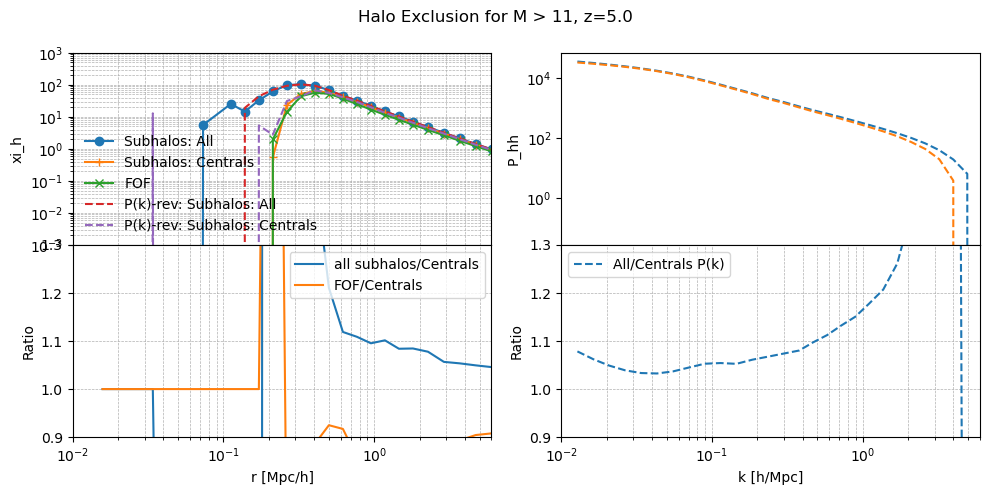

In [18]:
import h5py
import mcfit
from matplotlib import pyplot as plt

with h5py.File(f'/home/qezlou/HD2/HETDEX/cosmo/data/halo_exclusion/corr_all.h5', 'r') as f:
    mbins = f['mbins'][:]
    ind = mbins <= 60
    mbins = mbins[ind]
    result_all = f['result'][ind]

with h5py.File(f'/home/qezlou/HD2/HETDEX/cosmo/data/halo_exclusion/corr_cen.h5', 'r') as f:
    mbins = f['mbins'][:]
    ind = mbins <= 60
    mbins = mbins[ind]
    result_cen = f['result'][ind]

with h5py.File(f'/home/qezlou/HD2/HETDEX/cosmo/data/halo_exclusion/corr_fof_all.h5', 'r') as f:
    mbins = f['mbins'][:]
    ind = mbins <= 60
    mbins = mbins[ind]
    result_fof = f['result'][ind]

fig, ax = plt.subplots(2,2, figsize=(10, 5), sharex=True, gridspec_kw={'hspace': 0})

ax[0,0].plot(mbins, result_all, label='Subhalos: All', marker='o')
k, phh_all = mcfit.xi2P(mbins, l=0, lowring=True)(result_all, extrap=True)
ax[0,0].plot(mbins, result_cen, label='Subhalos: Centrals', marker='+')
ax[0,0].plot(mbins, result_fof, label='FOF', marker='x')

ax[0,1].plot(k, phh_all, label='All P(k)', linestyle='--')



r, xi_all_reversed = mcfit.P2xi(k, l=0, lowring=True)(phh_all, extrap=True)
ax[0,0].plot(r, xi_all_reversed, label='P(k)-rev: Subhalos: All', linestyle='--')

k, phh_cen = mcfit.xi2P(mbins, l=0, lowring=True)(result_cen, extrap=True)
ax[0,1].plot(k, phh_cen, label='Subhalos: Centrals P(k)', linestyle='--')
r, xi_cen_reversed = mcfit.P2xi(k, l=0, lowring=True)(phh_cen, extrap=True)
ax[0,0].plot(r, xi_cen_reversed, label='P(k)-rev: Subhalos: Centrals', linestyle='--')

ax[1,0].plot(mbins, result_all/result_cen, label='all subhalos/Centrals')
ax[1,0].plot(mbins, result_fof/result_cen, label='FOF/Centrals')
ax[1,1].plot(k, phh_all/phh_cen, label='All/Centrals P(k)', linestyle='--')

for i in range(2):
    ax[1,i].set_xlabel('r [Mpc/h]' if i==0 else 'k [h/Mpc]')
    ax[0,i].set_ylabel('xi_h' if i==0 else 'P_hh')
    ax[1,i].set_ylabel('Ratio')
    ax[0,i].set_xscale('log')
    ax[1,i].set_xscale('log')
    ax[0,i].set_yscale('log')
    ax[1,i].set_ylim(0.9, 1.3)
    ax[1,i].grid(which='both', linestyle='--', linewidth=0.5)
    ax[1,i].legend()
    ax[1, i].set_xlim((1e-2, 6))


ax[0,0].legend(frameon=False)
ax[0,0].set_ylim(1e-3, 1e3)

ax[0,0].grid(which='both', linestyle='--', linewidth=0.5)
fig.suptitle('Halo Exclusion for M > 11, z=5.0')
fig.tight_layout()


Lower mass closer tot the resolution limit:

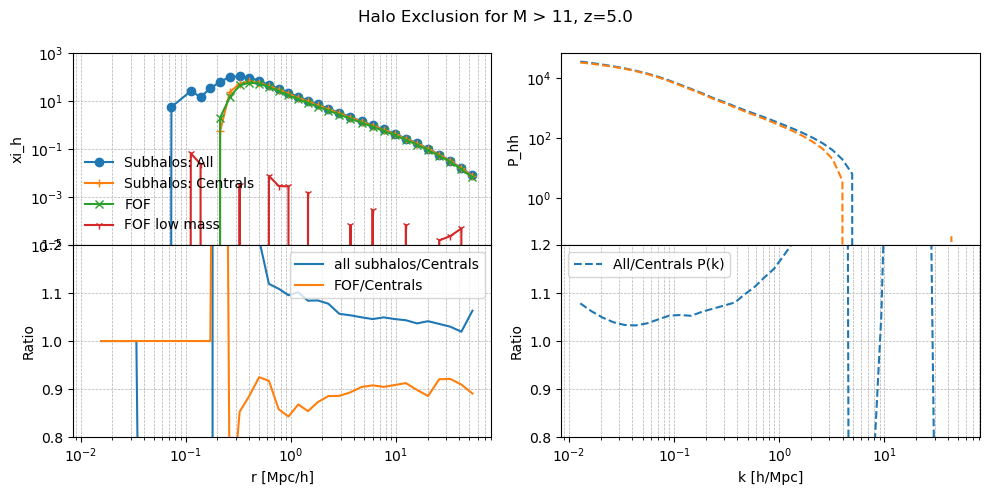

In [16]:
import h5py
import mcfit
from matplotlib import pyplot as plt

with h5py.File(f'/home/qezlou/HD2/HETDEX/cosmo/data/halo_exclusion/corr_all.h5', 'r') as f:
    mbins = f['mbins'][:]
    ind = mbins <= 60
    mbins = mbins[ind]
    result_all = f['result'][ind]

with h5py.File(f'/home/qezlou/HD2/HETDEX/cosmo/data/halo_exclusion/corr_cen.h5', 'r') as f:
    mbins = f['mbins'][:]
    ind = mbins <= 60
    mbins = mbins[ind]
    result_cen = f['result'][ind]

with h5py.File(f'/home/qezlou/HD2/HETDEX/cosmo/data/halo_exclusion/corr_fof_all.h5', 'r') as f:
    mbins = f['mbins'][:]
    ind = mbins <= 60
    mbins = mbins[ind]
    result_fof = f['result'][ind]

with h5py.File(f'/home/qezlou/HD2/HETDEX/cosmo/data/halo_exclusion/corr_fof_all_m_9_9.01.h5', 'r') as f:
    mbins = f['mbins'][:]
    ind = mbins <= 60
    mbins = mbins[ind]
    result_fof_lowmass = f['result'][ind]

fig, ax = plt.subplots(2,2, figsize=(10, 5), sharex=True, gridspec_kw={'hspace': 0})

ax[0,0].plot(mbins, result_all, label='Subhalos: All', marker='o')
k, phh_all = mcfit.xi2P(mbins, l=0, lowring=True)(result_all, extrap=True)
ax[0,0].plot(mbins, result_cen, label='Subhalos: Centrals', marker='+')
ax[0,0].plot(mbins, result_fof, label='FOF', marker='x')
ax[0,0].plot(mbins, result_fof_lowmass, label='FOF low mass', marker='1')

ax[0,1].plot(k, phh_all, label='All P(k)', linestyle='--')


k, phh_cen = mcfit.xi2P(mbins, l=0, lowring=True)(result_cen, extrap=True)
ax[0,1].plot(k, phh_cen, label='Subhalos: Centrals P(k)', linestyle='--')


ax[1,0].plot(mbins, result_all/result_cen, label='all subhalos/Centrals')
ax[1,0].plot(mbins, result_fof/result_cen, label='FOF/Centrals')
ax[1,1].plot(k, phh_all/phh_cen, label='All/Centrals P(k)', linestyle='--')

for i in range(2):
    ax[1,i].set_xlabel('r [Mpc/h]' if i==0 else 'k [h/Mpc]')
    ax[0,i].set_ylabel('xi_h' if i==0 else 'P_hh')
    ax[1,i].set_ylabel('Ratio')
    ax[0,i].set_xscale('log')
    ax[1,i].set_xscale('log')
    ax[0,i].set_yscale('log')
    ax[1,i].set_ylim(0.8, 1.2)
    ax[1,i].grid(which='both', linestyle='--', linewidth=0.5)
    ax[1,i].legend()


ax[0,0].legend(frameon=False)
ax[0,0].set_ylim(1e-5, 1e3)

ax[0,0].grid(which='both', linestyle='--', linewidth=0.5)
fig.suptitle('Halo Exclusion for M > 11, z=5.0')
fig.tight_layout()


#### Closer to ASTRID's res: